# P&D ISSP - Measurement post-processing

This Google Colab notebook was written for the KU Leuven P&D ISSP course's Impulse Response measurement session. 

**Colab functioning**:
> Google Colab functions just like a Python Jupyter notebook. Code is divided into *cells*, which can be run one at a time. 
To run a specific code cell, press the "*play*" button at the top left of the cell, or Ctrl+Enter (Windows), or Cmd+Enter (Mac)


---


--- Adapted from code by Randall Ali (ESAT) ---

Ref [1]: *Holters, M., Corbach, T., & Zölzer, U. (2009). Impulse response measurement techniques and their applicability in the real world. Proceedings of the 12th International Conference on Digital Audio Effects, DAFx 2009, 08–112.*

Ref [2]: *Farina, Angelo. "Simultaneous measurement of impulse response and distortion with a swept-sine technique." Audio engineering society convention 108. Audio Engineering Society, 2000.*

# Define your parameters

In [ ]:
fs = 44100          # Sampling Frequency [Hz] -- the sampling frequency of your signals (should be 44.1 kHz)
f1 = 1              # lower sweep freq [Hz]
f2 = fs/2           # upper sweep freq [Hz]

# Name of the ESS file used
essfname = 'myESS.wav'

# Name of the measured signal file(s)
fnames = ['ESStest_1.wav', 'ESStest_2.wav', 'ESStest_3.wav', 'ESStest_4.wav']

print('Parameters registered')

Parameters registered


# Compute inverse filter based on ESS

Text(0.5, 1.0, 'Inverse filter')

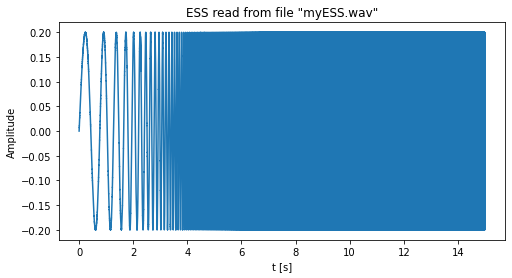

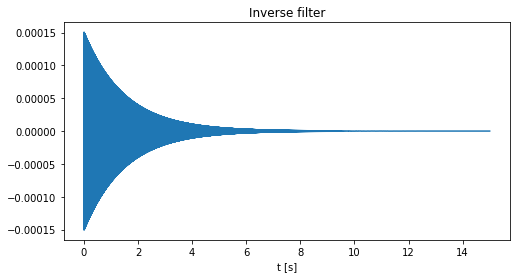

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal
from google.colab import output
output.enable_custom_widget_manager()
#%matplotlib widget

# Import IR
ess, fs_read = sf.read(essfname)
if fs != fs_read:
  raise ValueError('Something went wrong with the sampling frequency of the ESS')

# Check that the import is correct
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.plot(np.arange(len(ess))/fs, ess)
ax.set_xlabel('t [s]')
ax.set_ylabel('Amplitude')
ax.set_title(f'ESS read from file "{essfname}"')

# --------- Compute inverse filter ---------
# find the last zero crossing and set those last few samples to zero so that there will not be
# an abrupt transition to zero for the ending silence
zero_crossings = np.where(np.diff(np.sign(ess)))[0] 
ess[zero_crossings[-1]:] = 0

# Generate the convolutional inverse (See Holters et. al eq 9)
w1 = (2*np.pi*f1)/fs # rad/sample
w2 = (2*np.pi*f2)/fs
L = len(ess)                # number of samples
nn = np.arange(0, L, 1)     # samples for the sweep signal
b = (w2/w1)**(-nn/(L-1))
ess_inv = (np.flipud(ess) * b)

# Not sure if Holters et. al scaling in (10) was correct, but the following is the scaling obtain when we
# let n = L-1 in (6). It also takes into account the amplitude of the ESS
amplitude = np.amax(ess)
r = np.log(w2/w1)
xLinv = amplitude*(np.sin (((w1*(L-1))/r) * (np.exp((nn*r)/(L-1))-1))) * ((w2/w1)**(-(L-1-nn)/(L-1)))
C = np.sum(ess*xLinv)
inv_filter = ess_inv/C

# Show inverse filter
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.plot(np.arange(len(inv_filter))/fs, inv_filter)
ax.set_xlabel('t [s]')
ax.set_title(f'Inverse filter')


# Extract IR for each measured file

In [ ]:
from operator import inv
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal
import os

h = np.zeros((len(ess), len(fnames)))
for ii, fname in enumerate(fnames):
    # Read WAV as np.ndarray
    measuredSignal, fsdata = sf.read(fname)
    # Check sampling frequency
    if fs != fsdata:
        raise ValueError(f'The sampling frequencies of the ESS and the measured signal "{fname}" differ.')
    if len(measuredSignal) > len(inv_filter):
        print('The recording was stopped after the end of the sweep. Truncating recorded signal.')
        measuredSignalFinal = measuredSignal[:len(inv_filter)]
    else:
        measuredSignalFinal = measuredSignal

    # Compute the IR
    hcurr = signal.fftconvolve(inv_filter, measuredSignalFinal)
    h[:, ii] = hcurr[int(len(hcurr)/2):]

    # Export the IR as .wav
    if not os.path.exists('irs'):
      os.mkdir('irs')
    sf.write(f'irs/IR_{fname}', data=h[:, ii], samplerate=fs)
    print(f'Measured signal "{fname}" processed, IR exported as .wav.')


The recording was stopped after the end of the sweep. Truncating recorded signal.
Measured signal "ESStest_1.wav" processed, IR exported as .wav.
The recording was stopped after the end of the sweep. Truncating recorded signal.
Measured signal "ESStest_2.wav" processed, IR exported as .wav.
The recording was stopped after the end of the sweep. Truncating recorded signal.
Measured signal "ESStest_3.wav" processed, IR exported as .wav.
The recording was stopped after the end of the sweep. Truncating recorded signal.
Measured signal "ESStest_4.wav" processed, IR exported as .wav.


# Plots

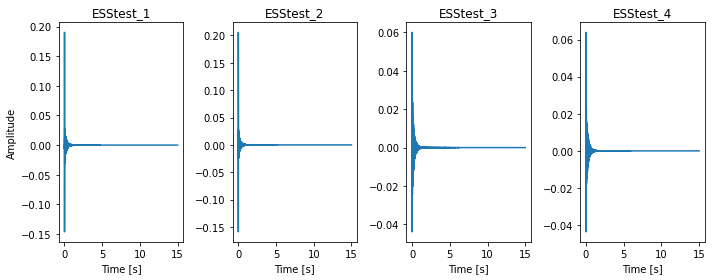

In [ ]:
import os 

# Prepare plots
time = np.arange(0, h.shape[0]/fs, 1/fs) 
fig = plt.figure(figsize=(10,4))
for ii in range(len(fnames)):
  ax = fig.add_subplot(1,len(fnames),ii+1)

  ax.plot(time, h[:, ii])   # only plot the "positive time half"
  ax.set_xlabel('Time [s]')
  if ii == 0:
    ax.set_ylabel('Amplitude')
  ax.set_title(f'{fnames[ii][:-4]}')

fig.tight_layout()
if not os.path.exists('figs'):
  os.mkdir('figs')
fig.savefig(f"figs/IRs.png")
plt.show()


# Bonus cell...

If you want to generate another sweep, this is how you do it :)

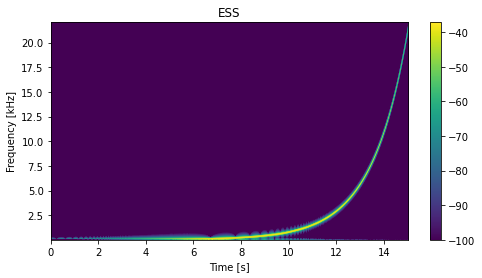

In [ ]:
import numpy as np
import os
from scipy import signal
import matplotlib.pyplot as plt

fs = 44100          # Sampling Frequency (Hz)
f1 = 1              # lower sweep freq (Hz)
f2 = fs/2           # upper sweep freq (Hz)
T_ess = 15          # time for sweep (s) 
A_ess = 0.2         # amplitude 

                  
w1 = (2*np.pi*f1)/fs # rad/sample
w2 = (2*np.pi*f2)/fs

L = T_ess*fs  # number of samples
nn = np.arange(0, L, 1)    # samples for the sweep signal

r = np.log(w2/w1)
ess = A_ess * np.sin (((w1*(L-1))/r) * (np.exp((nn*r)/(L-1))-1))

# Export as .wav
sf.write('./xCustom_ESS_T'+str(T_ess)+'_amp_'+str(A_ess)+'.wav',data=ess,samplerate=fs)

# Compute spectrogram
nfft = 512
noverlap = nfft//2
fxx, txx, Gxx = signal.spectrogram(ess, fs=fs,nperseg=nfft,window='hann',mode='psd',noverlap=noverlap)

# Plot
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
#
Gxx_dB = 10*np.log10(Gxx) 
cmin, cmax = -100, np.max(Gxx_dB)
sp0 = ax.imshow(Gxx_dB, origin='lower',aspect='auto',vmin=cmin,vmax=cmax,\
    extent=(0, T_ess, f1/1e3, f2/1e3))
ax.set_xlabel('Time [s]')
ax.set_ylabel('Frequency [kHz]')
ax.set_title('ESS')
cb0 = plt.colorbar(sp0,ax=ax) 

if not os.path.exists('figs'):
  os.mkdir('figs')
fig.savefig('figs/customESS.png')